In [4]:
import numpy as np

# Save fonts into pdf
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


import matplotlib.pyplot as plt
import tqdm.notebook
import scipy.integrate

import scipy.io as sio

In [5]:
matplotlib.rcParams.update({'font.size': 8, 'axes.linewidth': 0.5, 'xtick.major.width': 0.5, 'xtick.minor.width': 0.5, 
                            'ytick.major.width': 0.5,'ytick.minor.width': 0.5, 'xtick.major.pad':2,'ytick.major.pad':2})
matplotlib.rcParams.update({'font.family':'sans-serif','font.sans-serif':['Arial'], 'mathtext.default':'sf','mathtext.fontset':'custom'})

matplotlib.rcParams.update({'savefig.transparent':True})

In [6]:
hill = lambda x, k_d, n: np.power(x,n)/(k_d**n + np.power(x,n))

## Peak detector equations

In [7]:
rates = np.array([[10000,2000],[100,40], [5,7.5], [2000, 750], [2000, 500]])
km = np.array([[0.01,0.01], [0,0.1], [0.01,0.01], [0.01,0.01], [0.01, 0.01]])
k_switch_off = 100

def GKSwitchDynamicIntegrator2(t,y, scale_rate, scale_rate_2):
    dydt = np.zeros(5)

    dydt[0] = rates[0,0]*y[1]*(1-y[0])/(km[0,0] + 1 - y[0]) - rates[0,1]*y[0]/(km[0,1] + y[0])
    dydt[1] = -(rates[1,0] + k_switch_off*y[3])*y[1] + (rates[1,1]*y[0])*(1-y[1])/(1-y[1]+km[1,1])

    dydt[2] = rates[2,0]*y[0]*(1 - y[2])/(1 - y[2] + km[2,0]) - rates[2,1]*y[2]/(y[2]+km[2,1])*(1-y[0])

    dydt[3] = scale_rate[0]*y[2]*(1-y[3])/(km[3,0] + 1 - y[3]) - scale_rate[1]*y[3]/(km[3,1]+y[3])
    dydt[4] = scale_rate_2[0]*y[2]*(1-y[4])/(km[4,0] + 1 - y[4]) - scale_rate_2[1]*y[4]/(km[4,1]+y[4])
    return dydt

def GKSwitchDynamicIntegratorJac2(t,y, scale_rate, scale_rate_2):
    jac = np.zeros((5,5))

    jac[0,0] = rates[0,0]*y[1]*(-km[0,0]/(km[0,0]+1-y[0])**2) - rates[0,1]*km[0,1]/(km[0,1]+y[0])**2
    jac[0,1] = rates[0,0]*(1-y[0])/(km[0,0]+1-y[0])

    jac[1,0] = rates[1,1]*(1-y[1])/(1-y[1]+km[1,1])
    jac[1,1] = -(rates[1,0]+k_switch_off*y[3]) + (rates[1,1]*y[0])*(-km[1,1])/(1-y[1]+km[1,1])**2
    jac[1,3] = -k_switch_off*y[1]

    jac[2,0] = rates[2,1]*y[2]/(y[2]+km[2,1])
    # jac[2,1] = k_pr*scale_rate*(1-y[2])/(1-y[2]+km[2,0])
    jac[2,2] = rates[2,0]*y[0]*(-1)/(1-y[2]+km[2,0])**2 - rates[2,1]*(1-y[0])/(y[2]+km[2,1])**2

    jac[3,2] = scale_rate[0]*(1-y[3])/(km[3,0] + 1 - y[3])
    jac[3,3] = scale_rate[0]*y[2]*(-km[3,0])/(km[3,0]+1-y[3])**2 - scale_rate[1]/(km[3,1]+y[3])**2

    jac[4,2] = scale_rate_2[0]*(1-y[4])/(km[4,0] + 1 - y[4])
    jac[4,4] = scale_rate_2[0]*y[2]*(-km[4,0])/(km[4,0]+1-y[4])**2 - scale_rate_2[1]/(km[4,1]+y[4])**2

    return jac

In [9]:
dirs = ['06-17-1420','06-20-1430','06-22-0800','06-27-0905','06-28-2155']
i = -2
times_distrs = np.load('files/2022-'+dirs[i]+'/times0.1.npy')
rates_distr = np.load('files/2022-'+dirs[i]+'/rates0.1.npy')

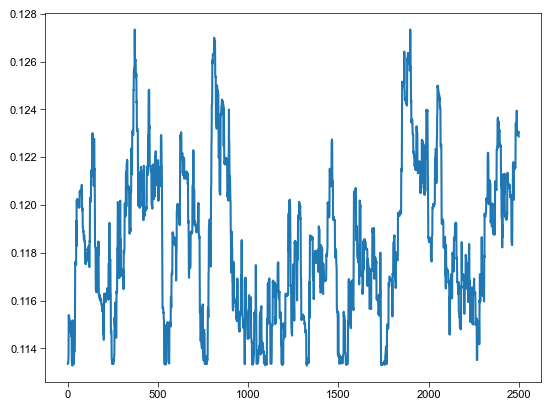

In [10]:
plt.plot(np.arange(len(times_distrs)), times_distrs)

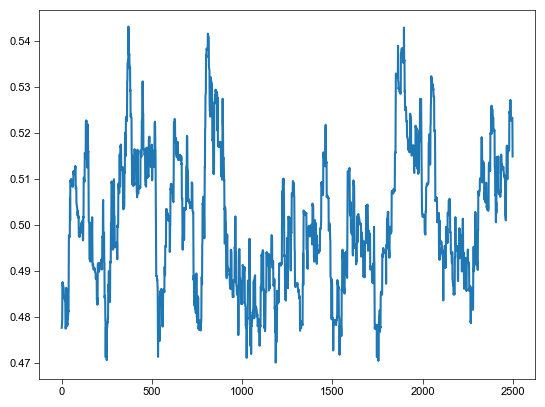

In [12]:
plt.plot(np.arange(len(rates_distr)), rates_distr)

In [15]:
dt = 1e-4 # Time step size (s)
T = 0.2 # Total time of simulation
t = np.arange(0, int(T/dt))*dt
dephos_rate = 5000

distr_ = np.exp(-((t - 120e-3)/(2*5e-3))**2)
distr_flat = np.ones(len(t))/len(t)

distr_weight = 0.1
distr = distr_/np.sum(distr_)*distr_weight + (1-distr_weight)*distr_flat
cdf = np.cumsum(distr)
get_interval = lambda r: np.interp(r, cdf, t)

## Initialize simulation
scale_rate_linear = np.mean(rates_distr) # scale_rate_linear_initial

# times = np.zeros(int(np.ceil(itrs/itr_report)))
# scale_rates = np.zeros(int(np.ceil(itrs/itr_report)))
y0 = np.array([0, 0.3,0,0, 0])

scale_rate_linear_2 = np.maximum(scale_rate_linear - 0.05, scale_rate_linear)

scale_rate = np.array([dephos_rate/scale_rate_linear, dephos_rate])
scale_rate_2 = np.array([dephos_rate/scale_rate_linear_2, dephos_rate])
sol = scipy.integrate.solve_ivp(lambda t,y: GKSwitchDynamicIntegrator2(t,y, scale_rate, scale_rate_2), (0, 0.2), y0,
                            jac=lambda t,y: GKSwitchDynamicIntegratorJac2(t,y,scale_rate, scale_rate_2),
                            method='BDF',max_step=1e-4)

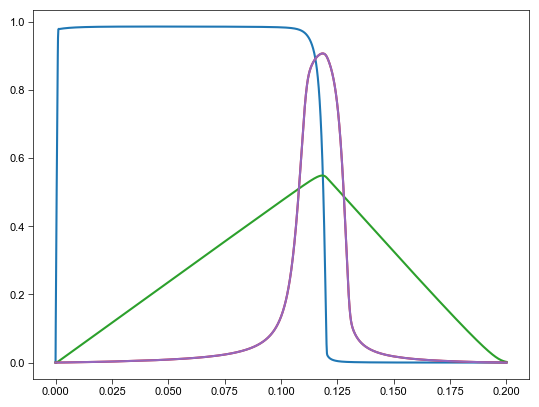

In [16]:
plt.plot(sol.t, sol.y[0,:], c='C0')
plt.plot(sol.t, sol.y[2,:], c='C2')
plt.plot(sol.t, sol.y[3,:], c='C3')
plt.plot(sol.t, sol.y[4,:], c='C4')

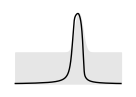

In [25]:
plt.figure(figsize=(1.5,1))

plt.fill_between(t, np.zeros(len(t)), distr, color=(0.9,)*3)
# plt.ylim([0, 0.0015])
plt.axis('off');
ax = plt.twinx()
ax.plot(sol.t, sol.y[4,:], c='k', lw=1)
plt.axis('off');
plt.savefig('figures/peak-detector-biochemical-result.pdf')

In [58]:
scale_rate_linear = 0.5
scale_rate_linear_2 = np.maximum(scale_rate_linear - 0.05, scale_rate_linear)

rate2 = 5000
scale_rate = np.array([rate2/scale_rate_linear, rate2])
scale_rate_2 = np.array([rate2/scale_rate_linear_2, rate2])
sol_1 = scipy.integrate.solve_ivp(lambda t,y: GKSwitchDynamicIntegrator2(t,y, scale_rate, scale_rate_2), (0, 0.2), y0,
                            jac=lambda t,y: GKSwitchDynamicIntegratorJac2(t,y,scale_rate, scale_rate_2),
                            method='BDF',max_step=1e-4) # , dense_output = True)


In [59]:
scale_rate_linear = 0.6
scale_rate_linear_2 = np.maximum(scale_rate_linear - 0.05, scale_rate_linear)

rate2 = 5000
scale_rate = np.array([rate2/scale_rate_linear, rate2])
scale_rate_2 = np.array([rate2/scale_rate_linear_2, rate2])
sol_2 = scipy.integrate.solve_ivp(lambda t,y: GKSwitchDynamicIntegrator2(t,y, scale_rate, scale_rate_2), (0, 0.2), y0,
                            jac=lambda t,y: GKSwitchDynamicIntegratorJac2(t,y,scale_rate, scale_rate_2),
                            method='BDF',max_step=1e-4) # , dense_output = True)


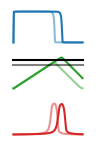

In [65]:
plt.figure(figsize=(1,1.5))

plt.subplot(3,1,1)
plt.plot(sol_1.t, sol_1.y[0,:], c='C0', alpha=0.5)
plt.plot(sol_2.t, sol_2.y[0,:], c='C0')
plt.axis('off')
plt.subplot(3,1,2)
plt.plot(sol_1.t, sol_1.y[2,:], c='C2', alpha=0.5)
# plt.plot(sol_2.t, sol_2.y[2,:], c='C2')
plt.plot(sol_2.t, sol_2.y[2,:], c='C2')
plt.plot([0, 0.2], [0.5,]*2, c='k',alpha=0.5)
plt.plot([0, 0.2], [0.6,]*2, c='k')
plt.axis('off')
plt.subplot(3,1,3)
plt.plot(sol_1.t, sol_1.y[3,:], c='C3', alpha=0.5)
plt.plot(sol_2.t, sol_2.y[3,:], c='C3')
plt.axis('off')

plt.tight_layout()
plt.savefig('figures/biochemical-timer-adjustment-shift.pdf')

# Median rule

In [43]:
dt = 1e-4 # Time step size (s)
T = 0.2 # Total time of simulation
t = np.arange(0, int(T/dt))*dt
dephos_rate = 5000

distr_ = np.exp(-((t - 120e-3)/(2*5e-3))**2)
distr_flat = np.ones(len(t))/len(t)

distr_weight = 0.1
distr = distr_/np.sum(distr_)*distr_weight + (1-distr_weight)*distr_flat
cdf = np.cumsum(distr)
get_interval = lambda r: np.interp(r, cdf, t)

## Initialize simulation
scale_rate_linear = 0.01 # np.mean(rates_distr) # scale_rate_linear_initial

# times = np.zeros(int(np.ceil(itrs/itr_report)))
# scale_rates = np.zeros(int(np.ceil(itrs/itr_report)))
y0 = np.array([0, 0.3,0,0, 0])

scale_rate_linear_2 = np.maximum(scale_rate_linear - 0.05, scale_rate_linear)

scale_rate = 100 # 1.1 ~= 200 ms
# scale_rate = np.array([dephos_rate/scale_rate_linear, dephos_rate])
scale_rates = np.array([dephos_rate*scale_rate, dephos_rate])
scale_rate_2 = np.array([dephos_rate/scale_rate_linear_2, dephos_rate])
sol = scipy.integrate.solve_ivp(lambda t,y: GKSwitchDynamicIntegrator2(t,y, scale_rates, scale_rate_2), (0, 0.2), y0,
                            jac=lambda t,y: GKSwitchDynamicIntegratorJac2(t,y,scale_rates, scale_rate_2),
                            method='BDF',max_step=1e-4)

In [39]:
1/0.01

100.0

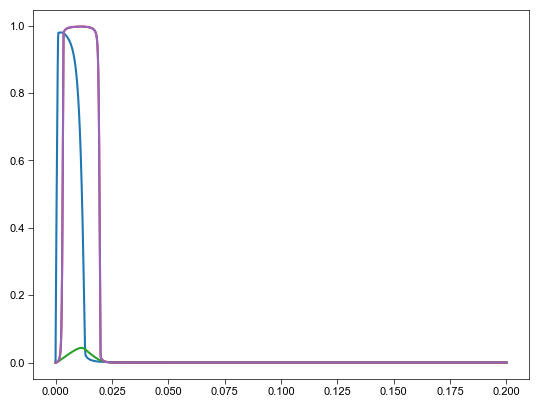

In [44]:
plt.plot(sol.t, sol.y[0,:], c='C0')
plt.plot(sol.t, sol.y[2,:], c='C2')
plt.plot(sol.t, sol.y[3,:], c='C3')
plt.plot(sol.t, sol.y[4,:], c='C4')

In [46]:
def simulateTimerAdjustmentMedian(itrs, distr_weight, itr_report = 1, scale_rate_linear_initial = 0.01, drate_scale = 0.01, dephos_rate = 5000 ):
    ## Define distribution
    dt = 1e-4 # Time step size (s)
    T = 0.2 # Total time of simulation
    t = np.arange(0, int(T/dt))*dt

    distr_ = np.exp(-((t - 120e-3)/(2*5e-3))**2)
    distr_flat = np.ones(len(t))/len(t)

    # distr_weight = 0.1
    distr = distr_/np.sum(distr_)*distr_weight + (1-distr_weight)*distr_flat
    cdf = np.cumsum(distr)
    get_interval = lambda r: np.interp(r, cdf, t)

    ## Initialize simulation
    scale_rate_linear = scale_rate_linear_initial

    times = np.zeros(int(np.ceil(itrs/itr_report)))
    scale_rates = np.zeros(int(np.ceil(itrs/itr_report)))
    y0 = np.array([0, 0.3,0,0, 0])

    for i in tqdm.notebook.trange(itrs, dynamic_ncols=True):

        scale_rate_linear_2 = np.maximum(scale_rate_linear - 0.05, scale_rate_linear)


        scale_rate = np.array([dephos_rate/scale_rate_linear, dephos_rate])
        scale_rate_2 = np.array([dephos_rate/scale_rate_linear_2, dephos_rate])
        sol = scipy.integrate.solve_ivp(lambda t,y: GKSwitchDynamicIntegrator2(t,y, scale_rate, scale_rate_2), (0, 0.2), y0,
                                    jac=lambda t,y: GKSwitchDynamicIntegratorJac2(t,y,scale_rate, scale_rate_2),
                                    method='BDF',max_step=1e-4)

        r = np.random.rand()
        spike_time =   get_interval(r) # get_interval_flat(r) #

        attrap_plus = np.interp(spike_time,  sol.t, 1-sol.y[0,:]) # (1-hill(sol.y[0,:], 0.01, 2)))
        attrap_minus = np.interp(spike_time,  sol.t, sol.y[0,:]) # hill(sol.y[0,:],0.01, 2))

        drate = drate_scale*(attrap_plus - attrap_minus)
        if drate > drate_scale: drate = drate_scale*0.001
        if drate < -drate_scale: drate = -drate_scale*0.001
        scale_rate_linear += drate
        if i%itr_report == 0:
            j = int(i/itr_report)
            times[j] = sol.t[np.argmax(sol.y[2,:])] # sol.t[np.where(sol.y[3,:]>0)[0][0]]
            scale_rates[j] = scale_rate_linear

        if scale_rate_linear < scale_rate_linear_initial: scale_rate_linear = scale_rate_linear_initial

    return times, scale_rates


In [55]:
def simulateTimerAdjustmentMedian(itrs, distr_weight, itr_report = 1, scale_rate_linear_initial = 0.01, drate_scale = 0.01, dephos_rate = 5000):
    ## Define distribution
    dt = 1e-4 # Time step size (s)
    T = 0.2 # Total time of simulation
    t = np.arange(0, int(T/dt))*dt

    distr_ = np.exp(-((t - 120e-3)/(2*5e-3))**2)
    distr_flat = np.ones(len(t))/len(t)

    # distr_weight = 0.1
    distr = distr_/np.sum(distr_)*distr_weight + (1-distr_weight)*distr_flat
    cdf = np.cumsum(distr)
    get_interval = lambda r: np.interp(r, cdf, t)

    ## Initialize simulation
    scale_rate_linear = scale_rate_linear_initial

    times = np.zeros(int(np.ceil(itrs/itr_report)))
    scale_rates_all = np.zeros(int(np.ceil(itrs/itr_report)))
    scale_rate = 1/scale_rate_linear_initial
    y0 = np.array([0, 0.3,0,0, 0])

    for i in tqdm.notebook.trange(itrs, dynamic_ncols=True):

        scale_rate_linear_2 = np.maximum(scale_rate_linear - 0.05, scale_rate_linear)

        # scale_rate = np.array([dephos_rate/scale_rate_linear, dephos_rate])
        scale_rates = np.array([dephos_rate*scale_rate, dephos_rate])
        scale_rate_2 = np.array([dephos_rate/scale_rate_linear_2, dephos_rate])
        sol = scipy.integrate.solve_ivp(lambda t,y: GKSwitchDynamicIntegrator2(t,y, scale_rates, scale_rate_2), (0, 0.2), y0,
                                    jac=lambda t,y: GKSwitchDynamicIntegratorJac2(t,y,scale_rates, scale_rate_2),
                                    method='BDF',max_step=1e-4)

        r = np.random.rand()
        spike_time =   get_interval(r) # get_interval_flat(r) #

        attrap_plus = np.interp(spike_time,  sol.t, 1-sol.y[0,:]) # (1-hill(sol.y[0,:], 0.01, 2)))
        attrap_minus = np.interp(spike_time,  sol.t, sol.y[0,:]) # hill(sol.y[0,:],0.01, 2))

        drate = drate_scale*(attrap_plus - attrap_minus)
        if drate > drate_scale: drate = drate_scale*0.001
        if drate < -drate_scale: drate = -drate_scale*0.001
        scale_rate -= drate*scale_rate**2
        scale_rate_linear += drate
        if i%itr_report == 0:
            j = int(i/itr_report)
            times[j] = sol.t[np.argmax(sol.y[2,:])] # sol.t[np.where(sol.y[3,:]>0)[0][0]]
            scale_rates_all[j] = scale_rate_linear

        if scale_rate_linear < scale_rate_linear_initial: scale_rate_linear = scale_rate_linear_initial

    return times, scale_rates


In [ ]:
d# 

In [56]:
times_med, scale_rates_med = simulateTimerAdjustmentMedian(10,1,
                                                           drate_scale = 0.001, itr_report = 1, scale_rate_linear_initial = 0.4)

  0%|                                                                                                         …

In [ ]:
times_med_2 = np.copy(times_med)
scale_rates_med_2 = np.copy( scale_rates_med )

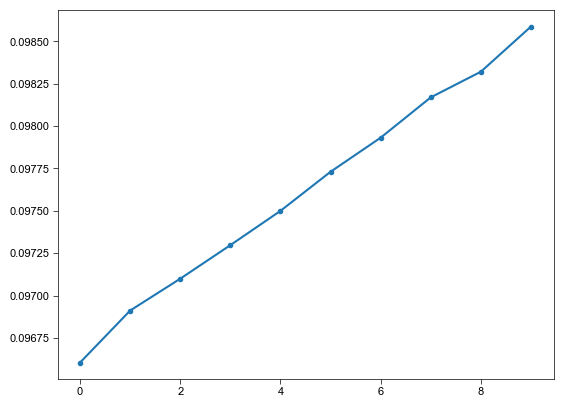

In [57]:
plt.plot(np.arange(len(times_med)), times_med,'.-')

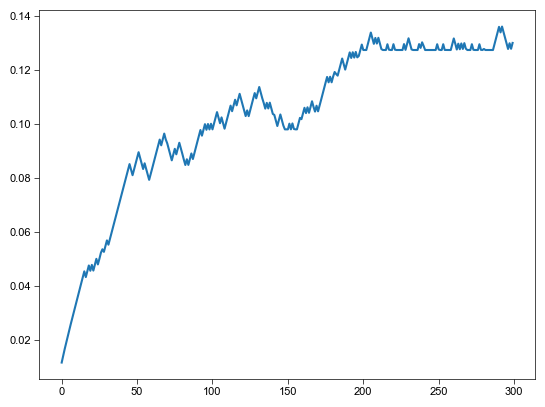

In [47]:
plt.plot(np.arange(len(times_med_1) + len(times_med_2)+ len(times_med)), 
         np.concatenate((times_med_1, times_med_2, times_med)))

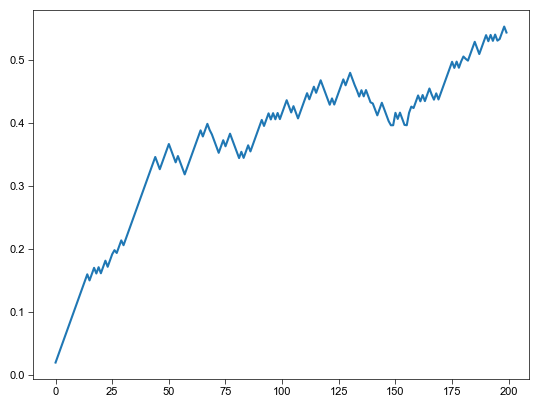

In [94]:
plt.plot(np.arange(len(scale_rates_med_1) + len(scale_rates_med_2)), 
         np.concatenate((scale_rates_med_1, scale_rates_med_2)))

In [48]:
scale_rates_med[-1]

0.5455864276391424

In [113]:
dt = 1e-4 # Time step size (s)
T = 0.2 # Total time of simulation
t = np.arange(0, int(T/dt))*dt
dephos_rate = 5000

distr_ = np.exp(-((t - 120e-3)/(2*5e-3))**2)
distr_flat = np.ones(len(t))/len(t)

distr_weight = 0.1
distr = distr_/np.sum(distr_)*distr_weight + (1-distr_weight)*distr_flat
cdf = np.cumsum(distr)
get_interval = lambda r: np.interp(r, cdf, t)

## Initialize simulation
scale_rate_linear =  scale_rates_med[-1]

# times = np.zeros(int(np.ceil(itrs/itr_report)))
# scale_rates = np.zeros(int(np.ceil(itrs/itr_report)))
y0 = np.array([0, 0.3,0,0, 0])

scale_rate_linear_2 = np.maximum(scale_rate_linear - 0.05, scale_rate_linear)

scale_rate = np.array([dephos_rate/scale_rate_linear, dephos_rate])
scale_rate_2 = np.array([dephos_rate/scale_rate_linear_2, dephos_rate])
sol = scipy.integrate.solve_ivp(lambda t,y: GKSwitchDynamicIntegrator2(t,y, scale_rate, scale_rate_2), (0, 0.2), y0,
                            jac=lambda t,y: GKSwitchDynamicIntegratorJac2(t,y,scale_rate, scale_rate_2),
                            method='BDF',max_step=1e-4, dense_output=True)

In [114]:
sol_out = sol.sol(t)

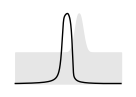

In [117]:
plt.figure(figsize=(1.5,1))

plt.fill_between(t, np.zeros(len(t)), distr, color=(0.9,)*3)
# plt.ylim([0, 0.0015])
plt.axis('off');
ax = plt.twinx()
ax.plot(t, sol_out[4,:], c='k', lw=1)
plt.axis('off');
plt.savefig('figures/median-biochemical-result.pdf')

In [83]:
np.sum(sol_out[0]*distr)

0.6485477109313248

In [84]:
np.sum((1-sol_out[0])*distr)

0.35145228906867526

In [105]:
distr = distr_/np.sum(distr_)*0.1 + (1-0.1)*distr_flat
cdf = np.cumsum(distr)
get_interval = lambda r: np.interp(r, cdf, t)


In [106]:
drates = np.zeros(1000)
for i in range(1000):
    r= np.random.rand()
    spike_time =   get_interval(r) 

    attrap_plus = np.interp(spike_time,  sol.t, (1-sol.y[0,:]))
    attrap_minus = np.interp(spike_time,  sol.t, sol.y[0,:])
    drates[i] = attrap_plus - attrap_minus

In [107]:
drate_scale = 0.001
drate = drate_scale*(attrap_plus - attrap_minus)

In [108]:
np.mean(drates)

0.08453235075110081

In [88]:
spike_time

0.07617101506750151

In [89]:
attrap_plus, attrap_minus

(0.014157371190547696, 0.9858426288094523)